In [1]:
import os
import gc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from datetime import datetime, timedelta
from catboost import Pool, CatBoostRegressor
from catboost.utils import get_gpu_device_count
pd.set_option('display.max_columns', None)
try:
    print('available GPU devices:', len(os.environ['CUDA_VISIBLE_DEVICES']), 
          ' | device num:', os.environ['CUDA_VISIBLE_DEVICES'])
except:
    print('no environ')
print('available GPU devices catboost:', get_gpu_device_count())

no environ
available GPU devices catboost: 1


In [2]:
DATA_DIR = 'C:/data/m5/data'
MODELS_DIR = 'C:/data/m5/models'
MODEL_VER = 'v0'
BACKWARD_LAGS = 60
CUT_DATE = '2015-01-01'
VAL_DATE = '2016-04-01'
END_DATE = '2016-04-24'
print(datetime.strptime(END_DATE, '%Y-%m-%d'))
#-----|CUT_DATE|---train---|VAL_DATE|--val--|END_DATE|--forecast +28 days-->

2016-04-24 00:00:00


In [3]:
CALENDAR_DTYPES = {
    'date':             'str',
    'wm_yr_wk':         'int16', 
    'weekday':          'object',
    'wday':             'int16', 
    'month':            'int16', 
    'year':             'int16', 
    'd':                'object',
    'event_name_1':     'object',
    'event_type_1':     'object',
    'event_name_2':     'object',
    'event_type_2':     'object',
    'snap_CA':          'int16', 
    'snap_TX':          'int16', 
    'snap_WI':          'int16'
}
PARSE_DATES = ['date']
SPRICES_DTYPES = {
    'store_id':    'object', 
    'item_id':     'object', 
    'wm_yr_wk':    'int16',  
    'sell_price':  'float32'
}

In [4]:
def get_df(is_train=True, backward_lags=None):
    strain = pd.read_csv('{}/sales_train_validation.csv'.format(DATA_DIR))
    print('read train:', strain.shape)
    cat_cols = ['id', 'item_id', 'dept_id','store_id', 'cat_id', 'state_id']
    last_day = int(strain.columns[-1].replace('d_', ''))
    print('last day is:', last_day)
    if not is_train:
        for day in range(last_day + 1, last_day + 28 + 28 + 1):
            strain['d_{}'.format(day)] = np.nan
    strain = pd.melt(
        strain,
        id_vars = cat_cols,
        value_vars = [col for col in strain.columns if col.startswith('d_')],
        var_name = 'd',
        value_name = 'sales'
    )
    print('melted train:', strain.shape)
    calendar = pd.read_csv('{}/calendar.csv'.format(DATA_DIR), dtype=CALENDAR_DTYPES, parse_dates=PARSE_DATES)
    print('read calendar:', calendar.shape)
    strain = strain.merge(calendar, on='d', copy=False)
    print('calendar merge done')
    sprices = pd.read_csv('{}/sell_prices.csv'.format(DATA_DIR), dtype=SPRICES_DTYPES)
    print('read prices:', sprices.shape)
    strain = strain.merge(
        sprices, 
        on=['store_id', 'item_id', 'wm_yr_wk'], 
        copy=False
    )
    print('prices merge done')
    print('begin train date:', strain['date'].min())
    print('end train date:', strain['date'].max())
    if not is_train:
        strain = strain.loc[
            strain['date'] >= (datetime.strptime(END_DATE, '%Y-%m-%d') - timedelta(days=backward_lags))
        ]
    else:
        strain = strain.loc[strain['date'] >= CUT_DATE]
    print('date cut train:', strain.shape)
    print('cut train date:', strain['date'].min())
    print('end train date:', strain['date'].max())
    return strain

In [5]:
def make_features(strain):
    print('in dataframe:', strain.shape)
    lags = [7, 28]
    windows= [7, 28]
    wnd_feats = [
        'id', 
        'item_id', 
        #'dept_id', 
        #'store_id', 
        #'cat_id', 
        #'state_id'
    ]
    lag_cols = ['lag_{}'.format(lag) for lag in lags ]
    for lag, lag_col in zip(lags, lag_cols):
        strain[lag_col] = strain[['id', 'sales']].groupby('id')['sales'].shift(lag)
    print('lag sales done')
    for wnd_feat in wnd_feats:
        for wnd in windows:
            for lag_col in lag_cols:
                wnd_col = '{}_{}_rmean_{}'.format(lag_col, wnd_feat, wnd)
                strain[wnd_col] = strain[[wnd_feat, lag_col]].groupby(wnd_feat)[lag_col].transform(
                    lambda x: x.rolling(wnd).mean()
                )
        print('rolling mean sales for feature done:', wnd_feat)
    date_features = {
        'week_num': 'weekofyear',
        'quarter': 'quarter',
        'mday': 'day'
    }
    for date_feat_name, date_feat_func in date_features.items():
        strain[date_feat_name] = getattr(strain['date'].dt, date_feat_func).astype('int16')
    print('date features done')
    strain['d'] = strain['d'].apply(lambda x: int(x.replace('d_', '')))  
    print('out dataframe:', strain.shape)
    return strain

In [6]:
%%time
strain = get_df(is_train=True, backward_lags=None)

read train: (30490, 1919)
last day is: 1913
melted train: (58327370, 8)
read calendar: (1969, 14)
calendar merge done
read prices: (6841121, 4)
prices merge done
begin train date: 2011-01-29 00:00:00
end train date: 2016-04-24 00:00:00
date cut train: (14535759, 22)
cut train date: 2015-01-01 00:00:00
end train date: 2016-04-24 00:00:00
Wall time: 1min 2s


In [7]:
%%time
strain = make_features(strain)

in dataframe: (14535759, 22)
lag sales done
rolling mean sales for feature done: id
rolling mean sales for feature done: item_id
date features done
out dataframe: (14535759, 35)
Wall time: 1min 43s


id to draw: FOODS_3_616_WI_3_validation
from 2015-01-01 00:00:00 to 2016-04-24 00:00:00
no features


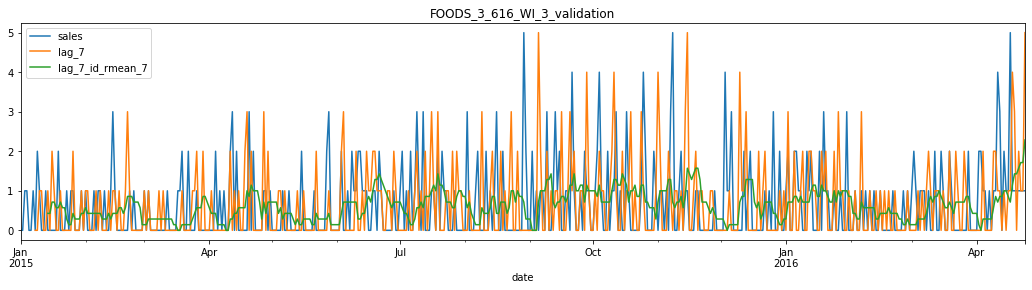

In [8]:
id_name = np.random.choice(strain['id'].unique())
print('id to draw:', id_name)
id_sales = strain.loc[strain['id'] == id_name].set_index('date')
print('from', strain['date'].min(), 'to', strain['date'].max()) 
plt.figure(figsize=(18, 4))
id_sales['sales'].plot(label='sales')
id_sales['lag_7'].plot(label='lag_7')
id_sales['lag_7_id_rmean_7'].plot(label='lag_7_id_rmean_7')
try:
    id_sales['lag_7_store_id_rmean_7'].plot(label='lag_7_store_id_rmean_7')
    id_sales['lag_7_cat_id_rmean_7'].plot(label='lag_7_cat_id_rmean_7')
except:
    print('no features')
    pass
plt.title(id_name)
plt.legend()
plt.show()

In [9]:
drop_cols = ['id', 'sales', 'date', 'wm_yr_wk', 'weekday']
train_cols = strain.columns[~strain.columns.isin(drop_cols)]
cat_cols = ['item_id', 'dept_id', 'store_id', 'cat_id', 'state_id', 
            'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']
strain[cat_cols] = strain[cat_cols].fillna(0)

In [10]:
%%time
train_pool = Pool(
    strain[train_cols], 
    strain['sales'],
    cat_features=cat_cols
)

Wall time: 38.9 s


In [11]:
%%time
model = CatBoostRegressor(
    iterations=1000,
    task_type='GPU', #'CPU'
    verbose=0,
    loss_function='RMSE',
    #boosting_type='Plain',
    #depth=6,
    #gpu_cat_features_storage='CpuPinnedMemory',
    #max_ctr_complexity=2
)
grid = {
    'depth': [4, 6, 8],
    'max_ctr_complexity': [1, 2, 4],
    'l2_leaf_reg': [1, 5, 9]
}
grid_search_result = model.grid_search(
    grid, 
    train_pool,
    cv=5,
    plot=True,
    verbose=0
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Wall time: 8h 30min 35s


In [12]:
model.save_model('{}/model_{}.cbm'.format(MODELS_DIR, MODEL_VER))

In [13]:
model = CatBoostRegressor().load_model('{}/model_{}.cbm'.format(MODELS_DIR, MODEL_VER))

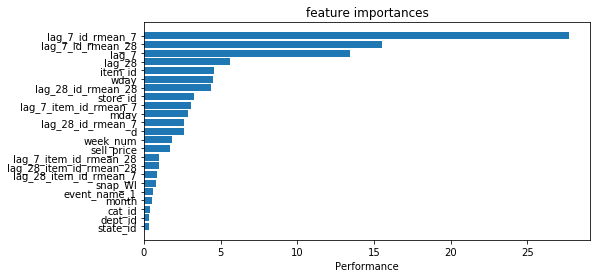

In [14]:
feat_importances = sorted(
    [(f, v) for f, v in zip(train_cols, model.get_feature_importance())],
    key=lambda x: x[1],
    reverse=True
)
threshold = .25
labels = [x[0] for x in feat_importances if x[1] > threshold]
values = [x[1] for x in feat_importances if x[1] > threshold]
fig, ax = plt.subplots(figsize=(8, 4))
y_pos = np.arange(len(labels))
ax.barh(y_pos, values)
ax.set_yticks(y_pos)
ax.set_yticklabels(labels)
ax.invert_yaxis()
ax.set_xlabel('Performance')
ax.set_title('feature importances')
plt.show()

In [15]:
spred = strain[strain['date'] >= VAL_DATE].copy()
preds = model.predict(spred[train_cols])
print('predictions done:', len(preds))
spred.loc[:, 'sales'] = preds

predictions done: 731760


id to draw: HOUSEHOLD_1_330_CA_2_validation
from 2015-01-01 00:00:00 to 2016-04-24 00:00:00


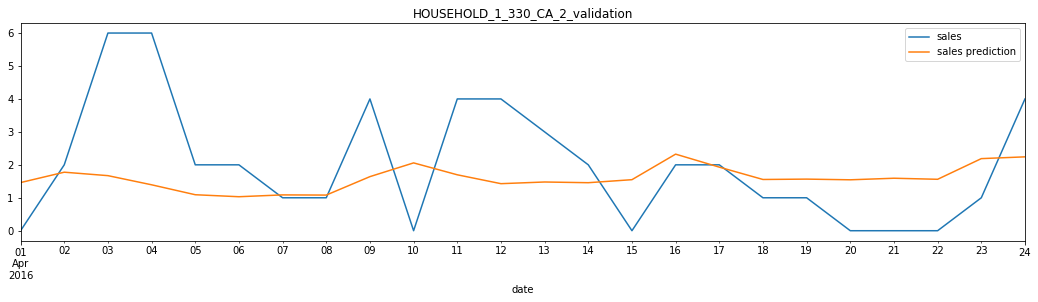

In [18]:
id_name = np.random.choice(strain['id'].unique())
print('id to draw:', id_name)
id_sales = strain.loc[(strain['id'] == id_name) & (strain['date'] >= VAL_DATE)].set_index('date')
id_sales_pred = spred.loc[spred['id'] == id_name].set_index('date')
print('from', strain['date'].min(), 'to', strain['date'].max()) 
plt.figure(figsize=(18, 4))
id_sales['sales'].plot(label='sales')
id_sales_pred['sales'].plot(label='sales prediction')
plt.title(id_name)
plt.legend()
plt.show()

In [19]:
%%time
growth_rate = 1
spred = get_df(is_train=False, backward_lags=BACKWARD_LAGS)
for pred_day in tqdm(range(1, 28 + 28 + 1)):
    pred_date = datetime.strptime(END_DATE, '%Y-%m-%d') + timedelta(days=pred_day)
    pred_date_back = pred_date - timedelta(days=BACKWARD_LAGS + 1)
    print('-' * 70)
    print('forecast day forward:', pred_day, '| forecast date:', pred_date) 
    spred_data = spred[(spred['date'] >= pred_date_back) & (spred['date'] <= pred_date)].copy()
    spred_data = make_features(spred_data)
    spred_data = spred_data.loc[spred['date'] == pred_date, train_cols]
    spred_data[cat_cols] = spred_data[cat_cols].fillna(0)
    spred.loc[spred['date'] == pred_date, 'sales'] = growth_rate * model.predict(spred_data)

read train: (30490, 1919)
last day is: 1913
melted train: (60034810, 8)
read calendar: (1969, 14)
calendar merge done
read prices: (6841121, 4)
prices merge done
begin train date: 2011-01-29 00:00:00
end train date: 2016-06-19 00:00:00
date cut train: (3567330, 22)
cut train date: 2016-02-24 00:00:00
end train date: 2016-06-19 00:00:00


----------------------------------------------------------------------
forecast day forward: 1 | forecast date: 2016-04-25 00:00:00
in dataframe: (1890380, 22)
lag sales done
rolling mean sales for feature done: id
rolling mean sales for feature done: item_id
date features done
out dataframe: (1890380, 35)
----------------------------------------------------------------------
forecast day forward: 2 | forecast date: 2016-04-26 00:00:00
in dataframe: (1890380, 22)
lag sales done
rolling mean sales for feature done: id
rolling mean sales for feature done: item_id
date features done
out dataframe: (1890380, 35)
----------------------------------------------------------------------
forecast day forward: 3 | forecast date: 2016-04-27 00:00:00
in dataframe: (1890380, 22)
lag sales done
rolling mean sales for feature done: id
rolling mean sales for feature done: item_id
date features done
out dataframe: (1890380, 35)
----------------------------------------------------------------------
forec

rolling mean sales for feature done: id
rolling mean sales for feature done: item_id
date features done
out dataframe: (1890380, 35)
----------------------------------------------------------------------
forecast day forward: 28 | forecast date: 2016-05-22 00:00:00
in dataframe: (1890380, 22)
lag sales done
rolling mean sales for feature done: id
rolling mean sales for feature done: item_id
date features done
out dataframe: (1890380, 35)
----------------------------------------------------------------------
forecast day forward: 29 | forecast date: 2016-05-23 00:00:00
in dataframe: (1890380, 22)
lag sales done
rolling mean sales for feature done: id
rolling mean sales for feature done: item_id
date features done
out dataframe: (1890380, 35)
----------------------------------------------------------------------
forecast day forward: 30 | forecast date: 2016-05-24 00:00:00
in dataframe: (1890380, 22)
lag sales done
rolling mean sales for feature done: id
rolling mean sales for feature do

in dataframe: (1890380, 22)
lag sales done
rolling mean sales for feature done: id
rolling mean sales for feature done: item_id
date features done
out dataframe: (1890380, 35)
----------------------------------------------------------------------
forecast day forward: 55 | forecast date: 2016-06-18 00:00:00
in dataframe: (1890380, 22)
lag sales done
rolling mean sales for feature done: id
rolling mean sales for feature done: item_id
date features done
out dataframe: (1890380, 35)
----------------------------------------------------------------------
forecast day forward: 56 | forecast date: 2016-06-19 00:00:00
in dataframe: (1890380, 22)
lag sales done
rolling mean sales for feature done: id
rolling mean sales for feature done: item_id
date features done
out dataframe: (1890380, 35)

Wall time: 1h 13min 14s


id to draw: HOUSEHOLD_2_130_TX_2_validation
from 2015-01-01 00:00:00 to 2016-06-19 00:00:00


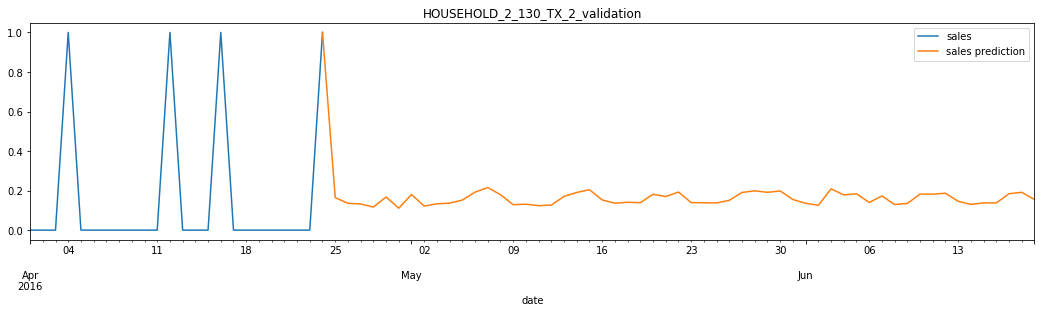

In [27]:
id_name = np.random.choice(strain['id'].unique())
print('id to draw:', id_name)
id_sales = strain.loc[(strain['id'] == id_name) & (strain['date'] >= VAL_DATE)].set_index('date')
id_sales_pred = spred.loc[(spred['id'] == id_name) & (spred['date'] >= END_DATE)].set_index('date')
print('from', strain['date'].min(), 'to', spred['date'].max()) 
plt.figure(figsize=(18, 4))
id_sales['sales'].plot(label='sales')
id_sales_pred['sales'].plot(label='sales prediction')
plt.title(id_name)
plt.legend()
plt.show()

In [28]:
spred_subm = spred.loc[spred['date'] > END_DATE, ['id', 'd', 'sales']].copy()
last_d = int(spred.loc[spred['date'] == END_DATE, 'd'].unique()[0].replace('d_', ''))
print('last d num:', last_d)
spred_subm['d'] = spred_subm['d'].apply(lambda x: 'F{}'.format(int(x.replace('d_', '')) - last_d))
spred_subm.loc[spred_subm['sales'] < 0, 'sales'] = 0

last d num: 1913


In [29]:
f_cols = ['F{}'.format(x) for x in range(1, 28 + 28 + 1)]
spred_subm = spred_subm.set_index(['id', 'd']).unstack()['sales'][f_cols].reset_index()
spred_subm.fillna(0, inplace=True)
spred_subm.sort_values('id', inplace=True)
spred_subm.reset_index(drop=True, inplace=True)
spred_subm.head()

d,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28,F29,F30,F31,F32,F33,F34,F35,F36,F37,F38,F39,F40,F41,F42,F43,F44,F45,F46,F47,F48,F49,F50,F51,F52,F53,F54,F55,F56
0,FOODS_1_001_CA_1_validation,0.910203,0.867025,0.865259,0.815091,0.957546,1.086398,1.074230,0.859010,0.809716,0.815321,0.788762,0.856455,1.111603,1.118059,0.923400,0.828894,0.854894,0.855277,0.880112,0.993865,0.997264,0.848688,0.743991,0.740151,0.749902,0.818958,0.976414,0.981872,0.719962,0.679102,0.676965,0.673255,0.735068,0.912136,0.943180,0.760084,0.710652,0.742543,0.708779,0.811125,0.929303,0.935267,0.737284,0.655257,0.695464,0.736655,0.765048,0.915551,0.918348,0.716436,0.663803,0.667829,0.641956,0.669477,0.825613,0.741871
1,FOODS_1_001_CA_2_validation,0.968125,0.891442,0.897574,0.954852,0.998327,1.108323,1.058661,0.858890,0.886552,0.905109,0.826354,0.948745,1.209418,1.107481,0.894144,0.822135,0.801387,0.793794,0.905416,1.127757,1.289892,0.957707,0.909651,0.908252,0.941743,0.979511,1.277113,1.141055,0.850620,0.787700,0.787246,0.765848,0.842283,1.082611,1.071828,0.835958,0.791018,0.799460,0.771354,0.899781,1.068985,1.103162,0.864916,0.782312,0.793976,0.794001,0.866229,1.071989,1.072797,0.829756,0.766505,0.770444,0.766854,0.828034,1.027953,0.956371
2,FOODS_1_001_CA_3_validation,1.119825,1.062713,1.022211,1.024178,1.037098,1.028495,0.763636,0.692892,0.728132,0.718678,0.739894,0.813724,1.091203,1.111328,0.914454,0.821312,0.845115,0.843057,0.857165,1.013938,1.027187,0.812654,0.777441,0.780822,0.776883,0.840559,1.053433,0.848815,0.666787,0.641047,0.682581,0.684745,0.747846,0.928960,1.020909,0.840345,0.731826,0.753015,0.737753,0.816406,0.916091,0.982438,0.830382,0.740882,0.758899,0.764781,0.790028,0.947134,0.972903,0.761727,0.709685,0.721396,0.689176,0.727263,0.894759,0.896572
3,FOODS_1_001_CA_4_validation,0.409696,0.406702,0.294169,0.296729,0.408712,0.395603,0.402197,0.297447,0.349142,0.360091,0.348789,0.395407,0.370115,0.352054,0.288889,0.270185,0.314006,0.305495,0.349483,0.357803,0.333114,0.262808,0.255562,0.272859,0.272135,0.348029,0.360549,0.405058,0.306421,0.307810,0.303942,0.303178,0.346528,0.330831,0.355419,0.303854,0.289356,0.306713,0.307933,0.391928,0.348774,0.337329,0.288079,0.278776,0.274631,0.274618,0.320178,0.314089,0.333261,0.285319,0.271688,0.274570,0.272324,0.313210,0.313292,0.291091
4,FOODS_1_001_TX_1_validation,0.287405,0.273732,0.195590,0.195962,0.226402,0.263589,0.268160,0.248434,0.301409,0.251982,0.256022,0.315903,0.360916,0.341916,0.335723,0.274845,0.316060,0.306155,0.319584,0.383451,0.398383,0.282583,0.267089,0.257560,0.256207,0.301748,0.356738,0.354942,0.272665,0.266059,0.264288,0.260578,0.298452,0.357906,0.379753,0.301186,0.293769,0.308774,0.330445,0.416468,0.380817,0.424209,0.355485,0.284699,0.323018,0.337177,0.343677,0.414532,0.419412,0.366360,0.355779,0.376002,0.332741,0.334307,0.368456,0.306490


In [30]:
f_cols = ['F{}'.format(x) for x in range(1, 28 + 1)]
f_cols_eval = ['F{}'.format(x) for x in range(28 + 1, 28 + 28 + 1)]
spred_subm_eval = spred_subm.copy()
spred_subm.drop(columns=f_cols_eval, inplace=True)
spred_subm_eval.drop(columns=f_cols, inplace=True)
spred_subm_eval.columns = spred_subm.columns
spred_subm_eval['id'] = spred_subm_eval['id'].str.replace('validation', 'evaluation')
spred_subm = pd.concat([spred_subm, spred_subm_eval], axis=0, sort=False)
spred_subm.reset_index(drop=True, inplace=True)
spred_subm.to_csv('submission.csv', index=False)
print('submission saved:', spred_subm.shape)

submission saved: (60980, 29)
